In [0]:
#!mkdir -p "data"
#!wget -N https://github.com/optima740/Dataset_01/raw/master/flowers_mini.zip -P "data"
#!unzip -o data/Alien_predator.zip -d data/



['alien', 'predator']


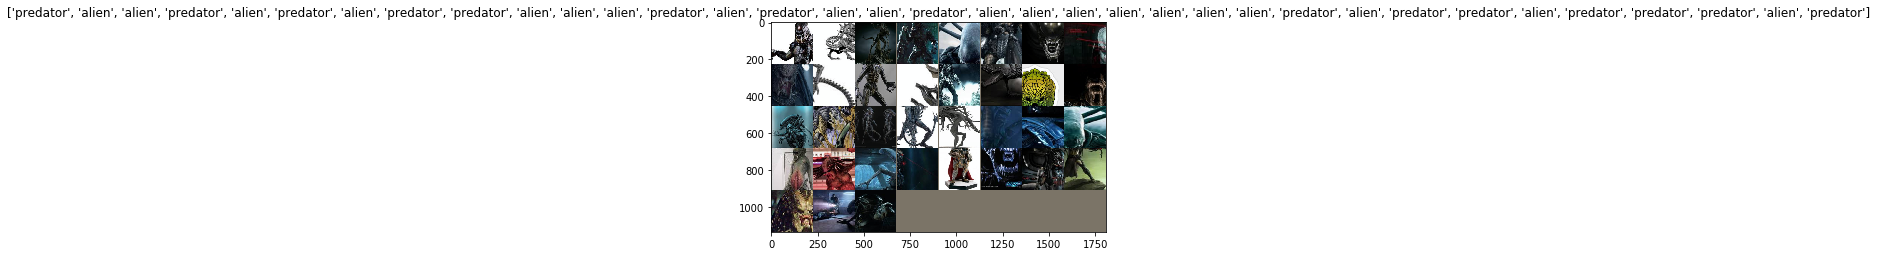

Epoch 0/27
----------
train Loss: 0.7309 Acc: 0.7186
val Loss: 0.3458 Acc: 0.8350

Epoch 1/27
----------
train Loss: 0.3403 Acc: 0.8413
val Loss: 0.4028 Acc: 0.8100

Epoch 2/27
----------
train Loss: 0.3527 Acc: 0.8456
val Loss: 0.2170 Acc: 0.9100

Epoch 3/27
----------
train Loss: 0.2579 Acc: 0.8788
val Loss: 0.3124 Acc: 0.8650

Epoch 4/27
----------
train Loss: 0.2654 Acc: 0.8817
val Loss: 0.1910 Acc: 0.9200

Epoch 5/27
----------
train Loss: 0.2729 Acc: 0.8773
val Loss: 0.3896 Acc: 0.8600

Epoch 6/27
----------
train Loss: 0.2423 Acc: 0.8903
val Loss: 0.1930 Acc: 0.9300

Epoch 7/27
----------
train Loss: 0.2123 Acc: 0.9105
val Loss: 0.2713 Acc: 0.8900

Epoch 8/27
----------
train Loss: 0.3245 Acc: 0.8716
val Loss: 0.2816 Acc: 0.8950

Epoch 9/27
----------
train Loss: 0.3223 Acc: 0.8788
val Loss: 0.2200 Acc: 0.9150

Epoch 10/27
----------
train Loss: 0.3167 Acc: 0.8759
val Loss: 0.1904 Acc: 0.9150

Epoch 11/27
----------
train Loss: 0.2314 Acc: 0.9076
val Loss: 0.1906 Acc: 0.9150

Ep

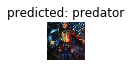

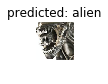

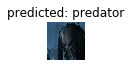

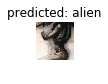

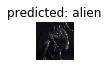

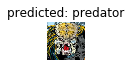

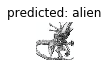

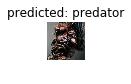

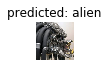

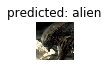

In [57]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

num_epochs = 28
batch_size = 35
lr=0.01
out_f = 2
# Выравнивание и нормализация входных изображений
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# загрузка двух датасетов
data_dir = 'data/Alien_predator'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

# вывод изображения
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# выводим очередную серию изображений    
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
##       
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, out_f)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr) #, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=12, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs)
##
visualize_model(model_conv)